In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%ls

Found GPU at: /device:GPU:0
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
'My Drive'/


In [5]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.568735851999975
GPU (s):
0.16955588400003307
GPU speedup over CPU: 21x


[](http://)#### This is a simple ANN to classify digits. Tuned parameters are Optimization Kernel, Learning Rate, trails to add 1or2 hidden layers and lastly adding drop out to achieve 98+% accuracy. A basic ANN notebook for submission Test Prediction on Digits. 

Later down below, images of Fashion items read (Fashion_MNIST dataset in Keras) and tried with CNN. For practice and tutorial for beginners. 

In [6]:
import pandas as pd
import numpy as np

np.random.seed(1212)

import keras
from keras.models import Model
from keras.layers import *
from keras.layers import Dense
from keras import optimizers

Using TensorFlow backend.


In [7]:
!pwd
!ls

/gdrive
'My Drive'


In [0]:
df_train = pd.read_csv('/gdrive/My Drive/MyLearning/MLDLAIPython/Data/TextData/MNIST_train.csv')
df_test = pd.read_csv('/gdrive/My Drive/MyLearning/MLDLAIPython/Data/TextData/MNISTtest.csv')
#images in these datasets are already flattened and in Machine readable format

In [9]:
df_train.head() # 784 features, 1 label

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
df_features = df_train.iloc[:, 1:785]
df_label = df_train.iloc[:, 0]

X_test = df_test.iloc[:, 0:784]

print(X_test.shape)

(28000, 784)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(df_features, df_label, test_size = 0.2, random_state = 42)
X_train = X_train.values.reshape(33600, 784) #(33600, 784)
X_cv = X_cv.values.reshape(8400, 784) #(8400, 784)
X_test = X_test.as_matrix().reshape(28000, 784)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [12]:
X_train.shape, X_cv.shape, y_train.shape, X_test.shape

((33600, 784), (8400, 784), (33600,), (28000, 784))

In [13]:
print((min(X_train[1]), max(X_train[1])))

(0, 254)


In [0]:
# Feature Normalization 
X_train = X_train.astype('float32'); 
X_cv    = X_cv.astype('float32'); 
X_test  = X_test.astype('float32')
X_train /= 255; 
X_cv    /= 255; 
X_test  /= 255

# Convert labels to One Hot Encoded
num_digits = 10
y_train = keras.utils.to_categorical(y_train, num_digits)
y_cv = keras.utils.to_categorical(y_cv, num_digits)

In [15]:
X_train.shape, X_cv.shape, y_train.shape, X_test.shape, y_cv.shape

((33600, 784), (8400, 784), (33600, 10), (28000, 784), (8400, 10))

In [16]:
# Printing 2 examples of labels after conversion
print(y_train[0]) # 2
print(y_train[3]) # 7

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


<font color=red size = 6>
  Model Fitting <br>
  <font color=brown size = 4>
We proceed by fitting several simple neural network models using Keras (with TensorFlow as our backend) and collect their accuracy. The model that performs the best on the validation set will be used as the model of choice for the competition.
<font color=red size = 6>
Model 1: Simple Neural Network with 4 layers (300, 100, 100, 200)
<font color=brown size = 4>
In our first model, we will use the Keras library to train a neural network with the activation function set as ReLu. To determine which class to output, we will rely on the SoftMax function

In [0]:
# Input Parameters
n_input = 784 # number of features
n_hidden_1 = 300
n_hidden_2 = 100
n_hidden_3 = 100
n_hidden_4 = 200
num_digits = 10

In [18]:
Inp = Input(shape=(784,))
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

In [19]:
# Our model would have '6' layers - input layer, 4 hidden layer and 1 output layer
model = Model(Inp, output)
model.summary() # We have 297,910 parameters to estimate

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 300)               235500    
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 100)               30100     
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 100)               10100     
_________________________________________________________________
Hidden_Layer_4 (Dense)       (None, 200)               20200     
_________________________________________________________________
Output_Layer (Dense)         (None, 10)                2010      
Total params: 297,910
Trainable params: 297,910
Non-trainable params: 0
_____________________________________________________

In [0]:
# Insert Hyperparameters
learning_rate = 0.1
training_epochs = 20
batch_size = 100
sgd = optimizers.SGD(lr=learning_rate)

In [21]:
# We rely on the plain vanilla Stochastic Gradient Descent as our optimizing methodology
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [22]:
history1 = model.fit(X_train, y_train,
                     batch_size = batch_size,
                     epochs = training_epochs,
                     verbose = 2,
                     validation_data=(X_cv, y_cv))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
 - 3s - loss: 1.8533 - acc: 0.4954 - val_loss: 1.0049 - val_acc: 0.7668
Epoch 2/20
 - 2s - loss: 0.6461 - acc: 0.8321 - val_loss: 0.4725 - val_acc: 0.8657
Epoch 3/20
 - 2s - loss: 0.4057 - acc: 0.8847 - val_loss: 0.3679 - val_acc: 0.8935
Epoch 4/20
 - 2s - loss: 0.3347 - acc: 0.9032 - val_loss: 0.3300 - val_acc: 0.9002
Epoch 5/20
 - 2s - loss: 0.2962 - acc: 0.9137 - val_loss: 0.2956 - val_acc: 0.9136
Epoch 6/20
 - 2s - loss: 0.2668 - acc: 0.9227 - val_loss: 0.2716 - val_acc: 0.9208
Epoch 7/20
 - 2s - loss: 0.2442 - acc: 0.9281 - val_loss: 0.2686 - val_acc: 0.9204
Epoch 8/20
 - 2s - loss: 0.2248 - acc: 0.9339 - val_loss: 0.2369 - val_acc: 0.9319
Epoch 9/20
 - 2s - loss: 0.2085 - acc: 0.9390 - val_loss: 0.2268 - val_acc: 0.9350
Epoch 10/20
 - 2s - loss: 0.1948 - acc: 0.9435 - val_loss: 0.2108 - val_acc: 0.9407
Epoch 11/20
 - 2s - loss:

In [23]:
_, val_acc1 = model.evaluate(X_cv, y_cv)
print (val_acc1)

8400/8400 [==============================] - 1s 60us/step
0.959047619047619


<font color=blue size = 4> 
Using a 4 layer neural network with:
20 training epochs
A training batch size of 100
Hidden layers set as (300, 100, 100, 200)
Learning rate of 0.1
Achieved Validation Accuracy (score) of around 95%. Do not consider Train Accuracy as it would(should) be close to 100%, since the model is getting trainned and exposed to all the Training data. We should concentrate on validation accuracy as that model has not seen that data. 
<br><font color=red size = 4>
Can we do better if we were to change the optimizer? To find out, we use the Adam optimizer for our second model, while maintaining the same parameter values for all other parameters

In [0]:
Inp = Input(shape=(784,))
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

# We rely on ADAM as our optimizing methodology
adam = keras.optimizers.Adam(lr=learning_rate)
model2 = Model(Inp, output)

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
history2 = model2.fit(X_train, y_train,
                      batch_size = batch_size,
                      epochs = training_epochs,
                      verbose = 2,
                      validation_data=(X_cv, y_cv))

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
 - 3s - loss: 0.3423 - acc: 0.8979 - val_loss: 0.1876 - val_acc: 0.9444
Epoch 2/20
 - 3s - loss: 0.1234 - acc: 0.9617 - val_loss: 0.1393 - val_acc: 0.9596
Epoch 3/20
 - 3s - loss: 0.0829 - acc: 0.9746 - val_loss: 0.1041 - val_acc: 0.9675
Epoch 4/20
 - 3s - loss: 0.0572 - acc: 0.9815 - val_loss: 0.1072 - val_acc: 0.9686
Epoch 5/20
 - 3s - loss: 0.0446 - acc: 0.9854 - val_loss: 0.0933 - val_acc: 0.9732
Epoch 6/20
 - 3s - loss: 0.0349 - acc: 0.9888 - val_loss: 0.1014 - val_acc: 0.9704
Epoch 7/20
 - 3s - loss: 0.0286 - acc: 0.9899 - val_loss: 0.1100 - val_acc: 0.9711
Epoch 8/20
 - 3s - loss: 0.0309 - acc: 0.9907 - val_loss: 0.1292 - val_acc: 0.9667
Epoch 9/20
 - 3s - loss: 0.0236 - acc: 0.9923 - val_loss: 0.0952 - val_acc: 0.9745
Epoch 10/20
 - 3s - loss: 0.0194 - acc: 0.9939 - val_loss: 0.1235 - val_acc: 0.9694
Epoch 11/20
 - 3s - loss: 0.0201 - acc: 0.9933 - val_loss: 0.1270 - val_acc: 0.9679
Epoch 12/20
 - 3s - loss: 0.0145 - a

In [26]:
_, val_acc2 = model2.evaluate(X_cv, y_cv)
print (val_acc2)

8400/8400 [==============================] - 0s 57us/step
0.9710714285714286


<font color=green size=4>
  As it turns out, it does appear to be the case that the optimizer plays a crucial part in the validation score. In particular, the model which relies on 'Adam' as its optimizer tend to perform 1.5 - 2.5% better on average. Going forward, we will use 'Adam' as our optimizer of choice.
<br><font color=brown size=4>
What if we changed the learning rate from 0.1 to 0.01, or 0.5? Will it have any impact on the accuracy? Model 2A

In [0]:
Inp = Input(shape=(784,))
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

learning_rate = 0.01
adam = keras.optimizers.Adam(lr=learning_rate)
model2a = Model(Inp, output)

model2a.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [28]:
history2a = model2a.fit(X_train, y_train,
                        batch_size = batch_size,
                        epochs = training_epochs,
                        verbose = 2,
                        validation_data=(X_cv, y_cv))

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
 - 3s - loss: 0.3340 - acc: 0.8996 - val_loss: 0.1573 - val_acc: 0.9527
Epoch 2/20
 - 3s - loss: 0.1248 - acc: 0.9627 - val_loss: 0.1349 - val_acc: 0.9581
Epoch 3/20
 - 3s - loss: 0.0797 - acc: 0.9762 - val_loss: 0.1383 - val_acc: 0.9590
Epoch 4/20
 - 3s - loss: 0.0596 - acc: 0.9808 - val_loss: 0.0969 - val_acc: 0.9704
Epoch 5/20
 - 3s - loss: 0.0449 - acc: 0.9860 - val_loss: 0.1166 - val_acc: 0.9675
Epoch 6/20
 - 3s - loss: 0.0359 - acc: 0.9883 - val_loss: 0.1217 - val_acc: 0.9673
Epoch 7/20
 - 3s - loss: 0.0301 - acc: 0.9903 - val_loss: 0.0966 - val_acc: 0.9750
Epoch 8/20
 - 3s - loss: 0.0231 - acc: 0.9927 - val_loss: 0.1129 - val_acc: 0.9712
Epoch 9/20
 - 3s - loss: 0.0225 - acc: 0.9926 - val_loss: 0.1155 - val_acc: 0.9692
Epoch 10/20
 - 3s - loss: 0.0217 - acc: 0.9928 - val_loss: 0.1467 - val_acc: 0.9669
Epoch 11/20
 - 3s - loss: 0.0221 - acc: 0.9928 - val_loss: 0.1114 - val_acc: 0.9739
Epoch 12/20
 - 3s - loss: 0.0185 - a

In [29]:
_, val_acc2a = model2a.evaluate(X_cv, y_cv)
print (val_acc2a)

8400/8400 [==============================] - 0s 58us/step
0.9741666666666666


<font color=green size=5>
  Model 2B

In [0]:
Inp = Input(shape=(784,))
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

learning_rate = 0.5
adam = keras.optimizers.Adam(lr=learning_rate)
model2b = Model(Inp, output)

model2b.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [31]:
history2b = model2b.fit(X_train, y_train,
                        batch_size = batch_size,
                        epochs = training_epochs,
                            validation_data=(X_cv, y_cv))

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
33600/33600 [==============================] - 3s 99us/step - loss: 0.3434 - acc: 0.8972 - val_loss: 0.1776 - val_acc: 0.9481
Epoch 2/20
33600/33600 [==============================] - 3s 81us/step - loss: 0.1239 - acc: 0.9624 - val_loss: 0.1194 - val_acc: 0.9623
Epoch 3/20
33600/33600 [==============================] - 3s 85us/step - loss: 0.0826 - acc: 0.9743 - val_loss: 0.1229 - val_acc: 0.9613
Epoch 4/20
33600/33600 [==============================] - 3s 89us/step - loss: 0.0579 - acc: 0.9821 - val_loss: 0.1191 - val_acc: 0.9637
Epoch 5/20
33600/33600 [==============================] - 3s 88us/step - loss: 0.0473 - acc: 0.9842 - val_loss: 0.0917 - val_acc: 0.9711
Epoch 6/20
33600/33600 [==============================] - 3s 87us/step - loss: 0.0340 - acc: 0.9894 - val_loss: 0.1101 - val_acc: 0.9682
Epoch 7/20
33600/33600 [==============================] - 3s 88us/step - loss: 0.0338 - acc: 0.9888 - val_loss: 0.1098 - val_acc:

In [32]:
_, val_acc2b = model2b.evaluate(X_cv, y_cv)
print (val_acc2b)

8400/8400 [==============================] - 0s 59us/step
0.9736904761904762


<font color=red size = 4> 
  The accuracy, as measured by the 3 different learning rates 0.01, 0.1 and 0.5 are around 98%, 97% and 98% respectively. As there are no considerable gains by changing the learning rates, we stick with the default learning rate of 0.01.
<br><font color=brown size = 4> <br>
We proceed to fit a neural network with 5 hidden layers with the features in the hidden layer set as (300, 100, 100, 100, 200) respectively. To ensure that the two models are comparable, we will set the training epochs as 20, and the training batch size as 100.

In [0]:
# Input Parameters
n_input = 784 # number of features
n_hidden_1 = 300
n_hidden_2 = 100
n_hidden_3 = 100
n_hidden_4 = 100
n_hidden_5 = 200
num_digits = 10

In [0]:
Inp = Input(shape=(784,))
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
x = Dense(n_hidden_5, activation='relu', name = "Hidden_Layer_5")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

In [35]:
# Our model would have '7' layers - input layer, 5 hidden layer and 1 output layer
model3 = Model(Inp, output)
model3.summary() # We have 308,010 parameters to estimate

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 300)               235500    
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 100)               30100     
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 100)               10100     
_________________________________________________________________
Hidden_Layer_4 (Dense)       (None, 100)               10100     
_________________________________________________________________
Hidden_Layer_5 (Dense)       (None, 200)               20200     
_________________________________________________________________
Output_Layer (Dense)         (None, 10)                2010

In [36]:
# We rely on 'Adam' as our optimizing methodology
adam = keras.optimizers.Adam(lr=0.01)

model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history3 = model3.fit(X_train, y_train,
                      batch_size = batch_size,
                      epochs = training_epochs,
                      validation_data=(X_cv, y_cv))

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
33600/33600 [==============================] - 4s 107us/step - loss: 0.3581 - acc: 0.8898 - val_loss: 0.1675 - val_acc: 0.9495
Epoch 2/20
33600/33600 [==============================] - 3s 86us/step - loss: 0.1235 - acc: 0.9616 - val_loss: 0.1196 - val_acc: 0.9626
Epoch 3/20
33600/33600 [==============================] - 3s 87us/step - loss: 0.0847 - acc: 0.9729 - val_loss: 0.1075 - val_acc: 0.9686
Epoch 4/20
33600/33600 [==============================] - 3s 87us/step - loss: 0.0642 - acc: 0.9796 - val_loss: 0.1213 - val_acc: 0.9651
Epoch 5/20
33600/33600 [==============================] - 3s 87us/step - loss: 0.0453 - acc: 0.9864 - val_loss: 0.1049 - val_acc: 0.9705
Epoch 6/20
33600/33600 [==============================] - 3s 86us/step - loss: 0.0395 - acc: 0.9867 - val_loss: 0.1120 - val_acc: 0.9688
Epoch 7/20
33600/33600 [==============================] - 3s 87us/step - loss: 0.0320 - acc: 0.9893 - val_loss: 0.1271 - val_acc

In [37]:
_, val_acc3 = model3.evaluate(X_cv, y_cv)
print (val_acc3)

8400/8400 [==============================] - 1s 64us/step
0.9757142857142858


<font color=red size=4>
  ompared to our first model, adding an additional layer did not significantly improve the accuracy from our previous model. However, there are computational costs (in terms of complexity) in implementing an additional layer in our neural network. Given that the benefits of an additional layer are low while the costs are high, we will stick with the 4 layer neural network.
<br><font color=brown size=4><br>
We now proceed to include dropout (dropout rate of 0.3) in our second model to prevent overfitting.

In [0]:
# Input Parameters
n_input = 784 # number of features
n_hidden_1 = 300
n_hidden_2 = 100
n_hidden_3 = 100
n_hidden_4 = 200
num_digits = 10

In [39]:
Inp = Input(shape=(784,))
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dropout(0.3)(x)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dropout(0.3)(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dropout(0.3)(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [40]:
# Our model would have '6' layers - input layer, 4 hidden layer and 1 output layer
model4 = Model(Inp, output)
model4.summary() # We have 297,910 parameters to estimate

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 784)               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 300)               235500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 100)               30100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0   

In [0]:
model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [42]:
history = model4.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = training_epochs,
                    validation_data=(X_cv, y_cv))

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
33600/33600 [==============================] - 4s 109us/step - loss: 0.5755 - acc: 0.8164 - val_loss: 0.1982 - val_acc: 0.9418
Epoch 2/20
33600/33600 [==============================] - 3s 88us/step - loss: 0.2225 - acc: 0.9349 - val_loss: 0.1555 - val_acc: 0.9561
Epoch 3/20
33600/33600 [==============================] - 3s 88us/step - loss: 0.1715 - acc: 0.9508 - val_loss: 0.1376 - val_acc: 0.9599
Epoch 4/20
33600/33600 [==============================] - 3s 88us/step - loss: 0.1363 - acc: 0.9606 - val_loss: 0.1233 - val_acc: 0.9656
Epoch 5/20
33600/33600 [==============================] - 3s 88us/step - loss: 0.1195 - acc: 0.9653 - val_loss: 0.1153 - val_acc: 0.9669
Epoch 6/20
33600/33600 [==============================] - 3s 89us/step - loss: 0.1061 - acc: 0.9685 - val_loss: 0.1036 - val_acc: 0.9707
Epoch 7/20
33600/33600 [==============================] - 3s 88us/step - loss: 0.0953 - acc: 0.9720 - val_loss: 0.1086 - val_acc

In [43]:
_, val_acc4 = model4.evaluate(X_cv, y_cv)
print (val_acc4)

8400/8400 [==============================] - 1s 67us/step
0.9785714285714285


In [44]:
eval_model = pd.DataFrame({
"Model": ['Model', 'Model2', 'Model2a', 'Model2b', 'Model3', 'Model4'],
    "Validation Accuracy" : [val_acc1, val_acc2, val_acc2a, val_acc2b, val_acc3, val_acc4]
   })

eval_model.sort_values(by = 'Validation Accuracy', ascending=False)

,Model,Validation Accuracy
5,Model4,0.978571
4,Model3,0.975714
2,Model2a,0.974167
3,Model2b,0.973690
1,Model2,0.971071
0,Model,0.959048


<font color=green size = 6> 
  With a validation score of close to 98%, we proceed to use this model to predict for the test set.

In [45]:
test_pred = pd.DataFrame(model4.predict(X_test, batch_size=200))
test_pred = pd.DataFrame(test_pred.idxmax(axis = 1))
test_pred.index.name = 'ImageId'
test_pred = test_pred.rename(columns = {0: 'Label'}).reset_index()
test_pred['ImageId'] = test_pred['ImageId'] + 1

test_pred.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [0]:
#test_pred.to_csv('kaggle_mnist_digits_submission.csv', index = False)

<font color=brown size=5> 
In the above example,  we read the numeric data of pixels to identify Digits. Now, we will read images and use CNN to identify if the input and classify it as one of the 10 fashion items.<br>
A convolutional neural network (CNN) is a neural network that can “see ” a subset of the data. It can detect a pattern in images better than perceptron.
   

In [0]:
# Import MNIST dataset which is already in Keras

from tensorflow.keras.datasets import fashion_mnist

# Import the Libraries

#Same as ANN
from keras.models import Sequential

# Related to CNN
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

#Same ANN Model
from keras.layers import Dense



In [67]:
# Get data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print('Training data shape : ', X_train.shape, y_train.shape)
print ('Test Shape ',  X_test.shape, y_test.shape)

Training data shape :  (60000, 28, 28) (60000,)
Test Shape  (10000, 28, 28) (10000,)


In [68]:
# Find the unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


Text(0.5, 1.0, 'Ground Truth : 9')

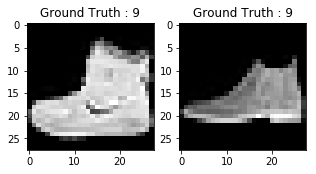

In [74]:
plt.figure(figsize=[5, 5])

#Display first image in training data
plt.subplot(121)
plt.imshow(X_train[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(y_train[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(X_test[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(y_test[0]))

<font color=brown size=4>
The image looks like an Ankle boot and Class assigned is 9. Similarly, other fashion items will have different Class. 
<br>
<font color=blue size=4>
As each image has dimension of 28 x 28, it has to be converted to 28 x 28 x 1 (3D) format. 

In [79]:
X_train = X_train.reshape(-1, 28,28, 1)
X_test = X_test.reshape(-1, 28,28, 1)
print ('Training datasets shapes', X_train.shape, X_test.shape)

X_train.dtype

Training datasets shapes (60000, 28, 28, 1) (10000, 28, 28, 1)


dtype('uint8')

CNN reads our images as is and hence flattening is not required. 
If you check your x_train, you will have 60,000 x 28 x 28 x 1 data. 
The data CNN needs to read must be like this: total_data x width x height x channels.
Height and width are self-explanatory. Channels are like Red or Green or Blue in RGB images. In RGB, because there are three channels, we need to make the data x 3. But because we work with grayscale images, every value on Red, Green, or Blue channel is the same and we reduce to one channel.

<font color=brown size=4> 
Right now data is in unit8 format. This is to be converted to float32.  Also, have to rescale the pixels values in 0 to 255 range.
<br>
<font color=blue size=4> 
The label field is in categorical form at present 0-9. This field needs to be one-hot encolded. For instance, Class 9 that denotes Ankle Boot after One-Hot encoded, it will be converted to [0 0 0 0 0 0 0 0 0 1], where in each is a new feature added to the dataset. 

In [82]:
# Change the labels from categorical to one-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Display the change for category label using one-hot encoding
print('Original label:', y_train[0])
print('After conversion to one-hot:', y_train_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Split the Training data now to set aside somed data for Validation. This is a good practice. we will use 20% of the Training data for validation. 

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_valid,label_train,label_valid = train_test_split(X_train, y_train_one_hot, test_size=0.2, random_state=13)

In [85]:
# Check the Shapes of the Train and  Validation Datasets
X_train.shape,X_valid.shape,label_train.shape, label_valid.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

In [0]:
# these were not included earlier but now will add these to use for better performance
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

The Model Architecture will have 
1. The first layer will have 32-3 x 3 filters,
2. The second layer will have 64-3 x 3 filters and
3. The third layer will have 128-3 x 3 filters.
4. In addition, there are three max-pooling layers each of size 2 x 2.

In Keras we can just stack up layers by adding desired layers one by one. We will start with Conv2D layer as we are handling images. 
We will make use to LeakyReLU activation function (instead of regular ReLU) as this function which helps the network to learn non-linear decision boundaries. There are 10 Classes and hence need non-linear decision boundary that could separate these 10 classes that are not linearly separable. Also, LeakyReLU works against dying neurons which is typically the cases in Convolutional NNs. This has been found effective as against the Logistic Sigmoid Function. 



In [0]:
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(Dense(num_classes, activation='softmax'))

In [90]:
fashion_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 128)        

<font color=brown size=3> 
1. Conv2d changed 28x28x1 image to 28x28x32, 28x28x64 and 28x28x128 respectively layers. These 32, 64 and 128 are like hidden layer cells.
2. MaxPooling2D reduces the width and height so that you will not need to compute all the cells. It reduces the size to 14x14x32 and further reduced to 7x7x64 and further to 4x4x128 in their respective layers. 
3. Flatten just flattens out the output of last MaxPooling into a hidden layer of 2048 cells


<font color=blue size=4> 
Compiling the model using Adam Optimizer which is by far found to be effective optimization algorithm. 
Loss type is "Categorical Cross Entropy" which is used for multi-class classification. Alternatively "Binary Cross Entropy" can also be used but that works better for "Binary Classifications". While compiling the model, we gather Accuracy Metrics that can be used for model evaluation. 

After compilation, we will set parameters for Training and start the training process. 




In [0]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [0]:
batch_size = 64
epochs = 20
num_classes = 10

In [95]:
fashion_train = fashion_model.fit(X_train, label_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_valid, label_valid))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 13s 270us/step - loss: 0.4614 - acc: 0.8327 - val_loss: 0.3249 - val_acc: 0.8805
Epoch 2/20
48000/48000 [==============================] - 12s 245us/step - loss: 0.2894 - acc: 0.8940 - val_loss: 0.2874 - val_acc: 0.8929
Epoch 3/20
48000/48000 [==============================] - 12s 243us/step - loss: 0.2406 - acc: 0.9118 - val_loss: 0.2483 - val_acc: 0.9109
Epoch 4/20
48000/48000 [==============================] - 12s 244us/step - loss: 0.2072 - acc: 0.9244 - val_loss: 0.2317 - val_acc: 0.9158
Epoch 5/20
48000/48000 [==============================] - 12s 247us/step - loss: 0.1827 - acc: 0.9331 - val_loss: 0.2398 - val_acc: 0.9128
Epoch 6/20
48000/48000 [==============================] - 12s 248us/step - loss: 0.1581 - acc: 0.9422 - val_loss: 0.2388 - val_acc: 0.9153
Epoch 7/20
48000/48000 [==============================] - 12s 246us/step - loss: 0.1396 - acc: 0.9484 - val_loss: 0.

<font color=brown size=4>
Training Accuracy is good at almost 99% but it is expected to be good. We should only be looking at Validation Accuracy and Validation Loss. Validation Accuracy is almost 92% which is good but <font color=red size=4> Validation Loss is 43% which is very high and could mean that its due to overfitting.
<br> <font color=brown size=4>
Loss  needs to be brought down as much as possible by using drop-out layer (purposefully omitts few neuros so that the model will not overlearn (overfitting) in subsequent Training trails. For now, lets get the evaluation of this model

In [98]:
test_eval = fashion_model.evaluate(X_test, y_test_one_hot, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.4463336690051016
Test accuracy: 0.9151


Let's put your model evaluation into perspective and plot the accuracy and loss plots between training and validation data:

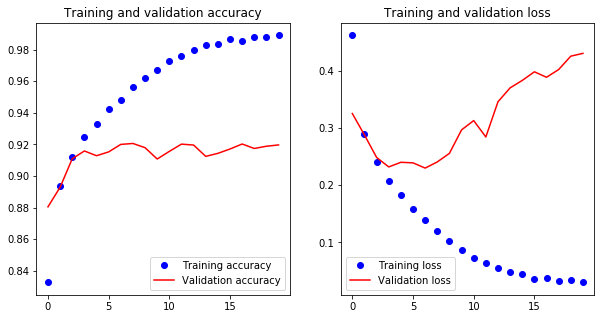

In [110]:
accuracy = fashion_train.history['acc']
val_accuracy = fashion_train.history['val_acc']
loss = fashion_train.history['loss']
val_loss = fashion_train.history['val_loss']
epochs = range(len(accuracy))
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy', color='red' )
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='red' )
plt.title('Training and validation loss')
plt.legend()
plt.show()

<font color=brown size=3> Point to Note from the Above plots is that, 
<font color=red size=3>
Validation Accuracy more or less hovered around the same accuracy after 3-4 epochs. It did increase linearly with validation loss but did not continue the trend after 3-4 epochs. This means that after 3-4 epochs model started memorizing the data. 
<font color=brown size=3>
Time to introduce Dropout layer

In [113]:
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(28,28,1)))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.4))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))           
fashion_model.add(Dropout(0.3))
fashion_model.add(Dense(num_classes, activation='softmax'))
fashion_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 64)         

In [0]:
batch_size = 64
epochs = 20
num_classes = 10

In [118]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

fashion_train_dropout = fashion_model.fit(X_train, label_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_valid, label_valid))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 14s 291us/step - loss: 0.5970 - acc: 0.7771 - val_loss: 0.3612 - val_acc: 0.8640
Epoch 2/20
48000/48000 [==============================] - 12s 246us/step - loss: 0.3771 - acc: 0.8621 - val_loss: 0.3148 - val_acc: 0.8852
Epoch 3/20
48000/48000 [==============================] - 12s 242us/step - loss: 0.3279 - acc: 0.8795 - val_loss: 0.2980 - val_acc: 0.8861
Epoch 4/20
48000/48000 [==============================] - 12s 244us/step - loss: 0.3006 - acc: 0.8892 - val_loss: 0.2698 - val_acc: 0.9016
Epoch 5/20
48000/48000 [==============================] - 12s 241us/step - loss: 0.2820 - acc: 0.8962 - val_loss: 0.2486 - val_acc: 0.9067
Epoch 6/20
48000/48000 [==============================] - 12s 243us/step - loss: 0.2653 - acc: 0.9022 - val_loss: 0.2426 - val_acc: 0.9112
Epoch 7/20
48000/48000 [==============================] - 12s 243us/step - loss: 0.2586 - acc: 0.9035 - val_loss: 0.

<font color=brown size=3>
Quick note is that the validation loss has come down by half from 43% to 21%. <br>
<font color=brown size=4>
Model Evaluation on the Test Set <br>
<font color=blue size=4>
Finally, let's also evaluate the new model to see how it performs!

In [121]:
test_eval = fashion_model.evaluate(X_test, y_test_one_hot, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

10000/10000 [==============================] - 1s 119us/step
Test loss: 0.22688650356531143
Test accuracy: 0.92


<font color=brown size=4>
Run the plots for visuialization enabling easy comparison 

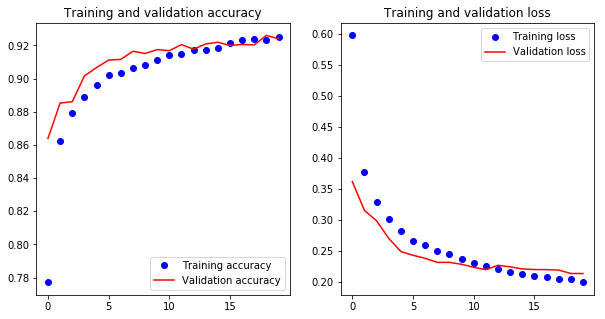

In [123]:
accuracy = fashion_train_dropout.history['acc']
val_accuracy = fashion_train_dropout.history['val_acc']
loss = fashion_train_dropout.history['loss']
val_loss = fashion_train_dropout.history['val_loss']
epochs = range(len(accuracy))
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy', color='red' )
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='red' )
plt.title('Training and validation loss')
plt.legend()
plt.show()

<font color=green size=4>
We can see that the validation loss and validation accuracy both are in sync with the training loss and training accuracy. Even though the validation loss and accuracy line are not linear, but it shows that this model is not overfitting: the validation loss is decreasing and not increasing, and there is not much gap between training and validation accuracy and infact this model did slight better on Validation loss compared to Training loss. <br>
<font color=brown size=5>
Will use this model to predict the Original Test dataset

In [0]:
predicted_classes = fashion_model.predict(X_test)

In [0]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [128]:
predicted_classes.shape, y_test.shape

((10000,), (10000,))

Found 9160 correct labels


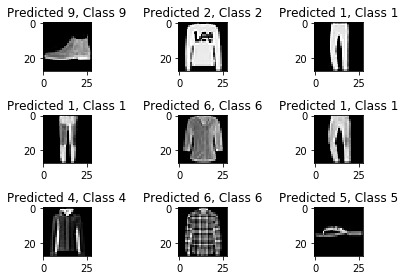

In [130]:
correct = np.where(predicted_classes==y_test)[0]
print ("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    plt.tight_layout()

Found 840 incorrect labels


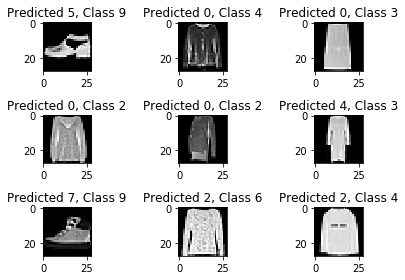

In [133]:
incorrect = np.where(predicted_classes!=y_test)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    plt.tight_layout()

In [134]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_test, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.78      0.90      0.84      1000
     Class 1       0.99      0.98      0.99      1000
     Class 2       0.85      0.91      0.88      1000
     Class 3       0.94      0.90      0.92      1000
     Class 4       0.87      0.86      0.87      1000
     Class 5       0.99      0.97      0.98      1000
     Class 6       0.84      0.71      0.77      1000
     Class 7       0.95      0.99      0.97      1000
     Class 8       0.99      0.98      0.99      1000
     Class 9       0.98      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



<font color=red size=4>
One can see that the classifier is underperforming for class 6 regarding both precision and recall. For class 0 and class 2, the classifier is lacking precision. Also, for class 4, the classifier is slightly lacking both precision and recall.